# Proyecto 2 Reconocimiento de Patrones

José Julián Camacho Hernández

Leonardo Guillén Fernández

In [2]:
import os
import cv2
import time
import math
import torch
import numpy as np
import pandas as pd
from PIL import Image
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from IPython.display import display
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, auc, roc_auc_score, roc_curve, f1_score

# MLP

In [3]:
def computeMetrics(y_test, y_pred, training_time):
    n_classes = 4
    acc = accuracy_score(y_test, y_pred)                        # Calcular la exactitud
    f1 = f1_score(y_test, y_pred, average='macro')              # Calcular F1 score
    rec = recall_score(y_test, y_pred, average='macro')         # Calcular el recall
    prec = precision_score(y_test, y_pred, average='macro')     # Calcular la precisión
    
    # Calcular macro AUC
    test_labels_binary = label_binarize(y_test, classes=np.unique(y_test))
    y_pred_one_hot = label_binarize(y_pred, classes=np.unique(y_test))
    n_classes = test_labels_binary.shape[1]
    auc_scores = []
    for i in range(n_classes):
        y_test_i = test_labels_binary[:, i]     
        y_pred_i = y_pred_one_hot[:, i]                 
        auc_i = roc_auc_score(y_test_i, y_pred_i)
        auc_scores.append(auc_i)
    macro_auc = np.mean(auc_scores)

    y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))
    y_pred_bin = np.zeros((len(y_test), n_classes))
    y_pred_bin[np.arange(len(y_test)), y_pred] = 1    
    metrics = {"Accuracy":acc, "Precision":prec, "Recall":rec, "F1 Score":f1, "AUC":macro_auc, "Tiempo de entrenamiento":training_time}
    df = pd.DataFrame(metrics, index = [0])
    display(df)

    # Calcular la curva ROC
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    plt.figure()
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label='Class {} (AUC = {:.2f})'.format(i, roc_auc[i]))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()


## MLP sin feature extractor

In [5]:
#=====  Cargar y aplicar feature extractor a las imágenes  =====#
X = []
y = []

input_folders = ["./testi3/", "./testi4/", "./testi2/", "./testi/"]
#input_folders = ["drive/MyDrive/COVID-19_Radiography_Dataset/COVID/", "drive/MyDrive/COVID-19_Radiography_Dataset/Lung_Opacity/",
#                 "drive/MyDrive/COVID-19_Radiography_Dataset/Normal/", "drive/MyDrive/COVID-19_Radiography_Dataset/Viral_Pneumonia/"]

i = 0
for folder in input_folders:
    input_folder = folder
    for filename in os.listdir(input_folder):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            image_path = os.path.join(input_folder, filename)
            image = cv2.imread(image_path)                                  # Leer la imagen
            cropped_image = image[20:280, 20:280]                           # Recortar los bordes
            gray_image = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2GRAY)    # Pasarla a escala de grises
            image_np = np.array(gray_image).flatten()                       # COnvertirla en array de 1D
            X.append(image_np)
            y.append(i)
    i+=1

np.save("X.npy", X)
np.save("y.npy", y)
#np.save("drive/MyDrive/X.npy", X)
#np.save("drive/MyDrive/y.npy", y)

In [15]:
#=====  Feature Engineering  =====#

try:
    X_charged = np.load("X.npy")
    y_charged = np.load("y.npy")
    #X_charged = np.load("drive/MyDrive/X.npy")
    #y_charged = np.load("drive/MyDrive/y.npy")
except FileNotFoundError:
    print("Error: File not found.")
       
# Convertir las listas a numpy array de tipo uint8
X_np = np.array(X_charged, dtype=np.uint8)
y_np = np.array(y_charged)

# Normalización de los datos
scaler = MinMaxScaler()
scaler.fit(X_np)
scaled_data = scaler.transform(X_np)
X_np = scaled_data

# Dividir los datos en train y test y estratificar
train_X, test_X, train_y, test_y = train_test_split(
    X_np, y_np, test_size=0.2, stratify=y_np, random_state=42)

# Convertir de numpy array a PyTorch tensor
X_train_tensor = torch.from_numpy(train_X).float()
X_test_tensor = torch.from_numpy(test_X).float()
y_train_tensor = torch.from_numpy(train_y).float()
y_test_tensor = torch.from_numpy(test_y).float()

# Convertir a tensores de tipo long
y_train_long_tensor = y_train_tensor.long()         

# Convertir a one hot
y_onehot = F.one_hot(y_train_long_tensor, num_classes=4).float()


In [16]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, num_classes, activation):
        super(MLP, self).__init__()
        self.input_size = input_size
        self.hidden_layers = nn.ModuleList()
        self.num_classes = num_classes
        self.activation = activation
        # Agregar capas ocultas
        for i, hidden_size in enumerate(hidden_sizes):
            if i == 0:
                self.hidden_layers.append(nn.Linear(input_size, hidden_size))
            else:
                self.hidden_layers.append(nn.Linear(hidden_sizes[i-1], hidden_size))
        # Capa de salida
        self.output_layer = nn.Linear(hidden_sizes[-1], num_classes)
        
    def forward(self, x):
        out = x
        # Pasar por capas ocultas
        for layer in self.hidden_layers:
            out = layer(out)
            out = self.activation(out)
        # Pasar por capa de salida
        out = self.output_layer(out)
        return out

### Diseño # 1
Capas: [67600, 128, 64, 4] | Función de activación: ReLU | epochs = 100

==========  Entrenando el modelo  ==========

Epoch: 10/100, Loss: 2.3306758403778076
Epoch: 20/100, Loss: 0.817893385887146
Epoch: 30/100, Loss: 0.6210305094718933
Epoch: 40/100, Loss: 0.5240660309791565
Epoch: 50/100, Loss: 0.4442124366760254
Epoch: 60/100, Loss: 0.38193613290786743
Epoch: 70/100, Loss: 0.33049875497817993
Epoch: 80/100, Loss: 0.2854495942592621
Epoch: 90/100, Loss: 0.24607254564762115
Epoch: 100/100, Loss: 0.21133160591125488

==========  Resultados conjunto de prueba  ==========



,Accuracy,Precision,Recall,F1 Score,AUC,Tiempo de entrenamiento
0,0.592593,0.569444,0.539583,0.538919,0.702535,10.584102


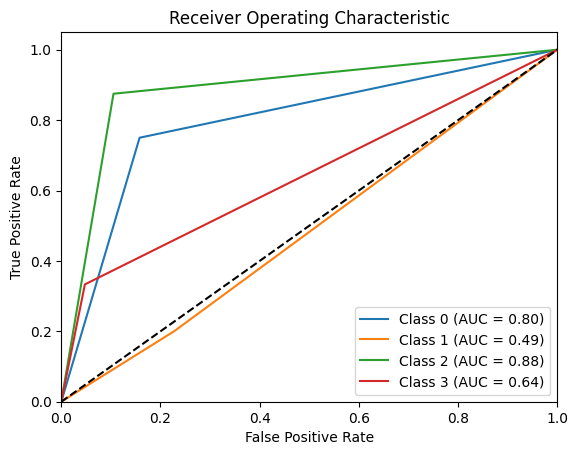

Resultados esperados:  tensor([1., 0., 0., 3., 2., 2., 0., 2.])
Resultados obtenidos:  tensor([0, 1, 0, 3, 2, 2, 0, 2])

==========  Resultados conjunto de entrenamiento  ==========



,Accuracy,Precision,Recall,F1 Score,AUC,Tiempo de entrenamiento
0,0.971154,0.977941,0.960526,0.967033,0.975126,10.584102


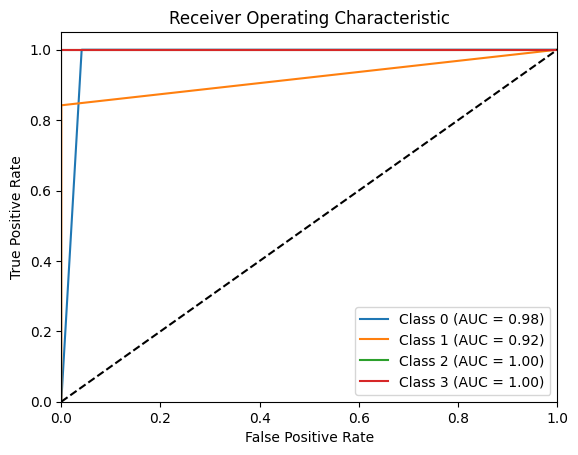

Resultados esperados:  tensor([3., 3., 0., 0., 0., 2., 2., 1.])
Resultados obtenidos:  tensor([3, 3, 0, 0, 0, 2, 2, 0])


In [39]:
#=====  Instaciar modelo  =====#
input_size = X_train_tensor.shape[1]
hidden_sizes = [128, 64]       
num_classes = 4
activation = F.relu
model = MLP(input_size, hidden_sizes, num_classes, activation)   

# Definir la función de loss y optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
num_epochs = 100
print('|==========  Entrenando el modelo  ==========|\n')
start_time = time.time()
# Entrenar el modelo
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_onehot)
    loss.backward()
    optimizer.step()
    # Imprimir el training loss
    if (epoch+1) % 10 == 0:
        print(f"Epoch: {epoch+1}/{num_epochs}, Loss: {loss.item()}")
end_time = time.time()
time_taken = end_time - start_time

print('\n|==========  Resultados conjunto de prueba  ==========|\n')
# Evaluar el modelo con el conjunto de testing
outputs = model(X_test_tensor)
_, predicted = torch.max(outputs.data, 1)

# Obtener métricas
computeMetrics(y_test_tensor, predicted, time_taken)
print('Resultados esperados: ', y_test_tensor[:8])
print('Resultados obtenidos: ', predicted[:8])

print('\n1==========  Resultados conjunto de entrenamiento  ==========|\n')
# Evaluar el modelo con el conjunto de training
outputs = model(X_train_tensor)
_, predicted = torch.max(outputs.data, 1)

# Obtener métricas
computeMetrics(y_train_tensor, predicted, time_taken)
print('Resultados esperados: ', y_train_tensor[:8])
print('Resultados obtenidos: ', predicted[:8])

### Diseño # 2
Capas: [67600, 256, 4] | Función de activación: ReLU | epochs = 100

|==========  Entrenando el modelo  ==========|

Epoch: 10/100, Loss: 8.078959465026855
Epoch: 20/100, Loss: 3.4454574584960938
Epoch: 30/100, Loss: 0.9928983449935913
Epoch: 40/100, Loss: 0.9221662282943726
Epoch: 50/100, Loss: 0.5310888886451721
Epoch: 60/100, Loss: 0.34985587000846863
Epoch: 70/100, Loss: 0.26925885677337646
Epoch: 80/100, Loss: 0.2194667011499405
Epoch: 90/100, Loss: 0.1844841092824936
Epoch: 100/100, Loss: 0.16202698647975922

|==========  Resultados conjunto de prueba  ==========|



,Accuracy,Precision,Recall,F1 Score,AUC,Tiempo de entrenamiento
0,0.555556,0.541071,0.508333,0.502778,0.679434,21.811606


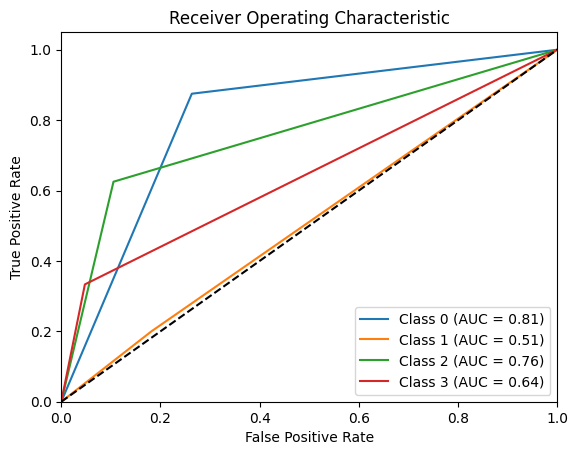

Resultados esperados:  tensor([1., 0., 0., 3., 2., 2., 0., 2.])
Resultados obtenidos:  tensor([0, 1, 0, 3, 2, 2, 0, 2])

|==========  Resultados conjunto de entrenamiento  ==========|



,Accuracy,Precision,Recall,F1 Score,AUC,Tiempo de entrenamiento
0,0.980769,0.984848,0.982759,0.983259,0.987955,21.811606


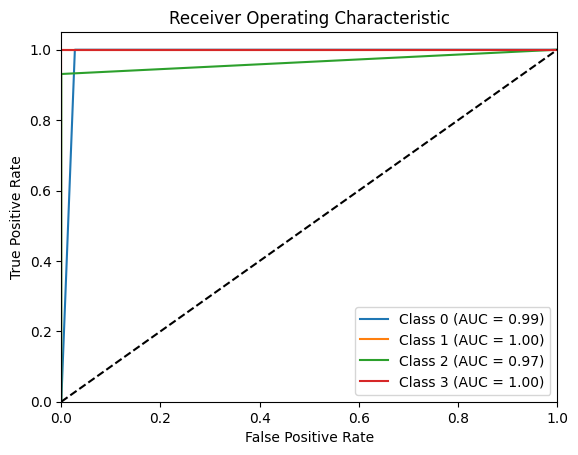

Resultados esperados:  tensor([3., 3., 0., 0., 0., 2., 2., 1.])
Resultados obtenidos:  tensor([3, 3, 0, 0, 0, 0, 2, 1])


In [17]:
#=====  Instaciar modelo  =====#
input_size = X_train_tensor.shape[1]
hidden_sizes = [256]       
num_classes = 4
activation = F.relu
model = MLP(input_size, hidden_sizes, num_classes, activation)   

# Definir la función de loss y optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
num_epochs = 100
print('|==========  Entrenando el modelo  ==========|\n')
start_time = time.time()
# Entrenar el modelo
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_onehot)
    loss.backward()
    optimizer.step()
    # Imprimir el training loss
    if (epoch+1) % 10 == 0:
        print(f"Epoch: {epoch+1}/{num_epochs}, Loss: {loss.item()}")
end_time = time.time()
time_taken = end_time - start_time

print('\n|==========  Resultados conjunto de prueba  ==========|\n')
# Evaluar el modelo con el conjunto de testing
outputs = model(X_test_tensor)
_, predicted = torch.max(outputs.data, 1)

# Obtener métricas
computeMetrics(y_test_tensor, predicted, time_taken)
print('Resultados esperados: ', y_test_tensor[:8])
print('Resultados obtenidos: ', predicted[:8])

print('\n|==========  Resultados conjunto de entrenamiento  ==========|\n')
# Evaluar el modelo con el conjunto de training
outputs = model(X_train_tensor)
_, predicted = torch.max(outputs.data, 1)

# Obtener métricas
computeMetrics(y_train_tensor, predicted, time_taken)
print('Resultados esperados: ', y_train_tensor[:8])
print('Resultados obtenidos: ', predicted[:8])

### Diseño # 3
Capas: [67600, 64, 64, 64, 64, 4] | Función de activación: ReLU | epochs = 100

|==========  Entrenando el modelo  ==========|

Epoch: 10/100, Loss: 1.229271650314331
Epoch: 20/100, Loss: 0.8646478652954102
Epoch: 30/100, Loss: 0.6027638912200928
Epoch: 40/100, Loss: 0.41682034730911255
Epoch: 50/100, Loss: 0.2688087821006775
Epoch: 60/100, Loss: 0.21893693506717682
Epoch: 70/100, Loss: 0.15748389065265656
Epoch: 80/100, Loss: 0.0833951085805893
Epoch: 90/100, Loss: 0.06246062368154526
Epoch: 100/100, Loss: 0.039451997727155685

|==========  Resultados conjunto de prueba  ==========|



,Accuracy,Precision,Recall,F1 Score,AUC,Tiempo de entrenamiento
0,0.666667,0.63125,0.6125,0.613194,0.751255,5.588417


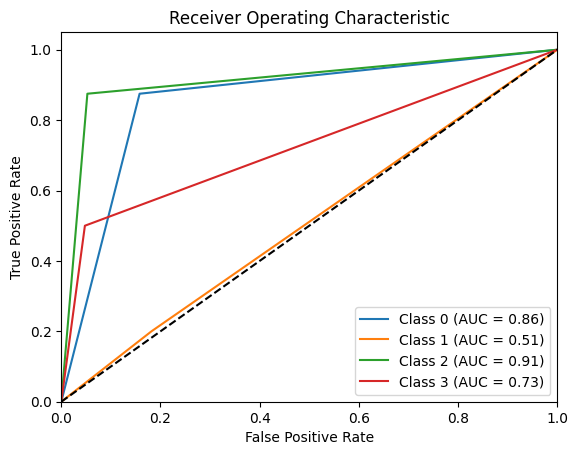

Resultados esperados:  tensor([1., 0., 0., 3., 2., 2., 0., 2.])
Resultados obtenidos:  tensor([0, 1, 0, 3, 2, 2, 0, 2])

1==========  Resultados conjunto de entrenamiento  ==========|



,Accuracy,Precision,Recall,F1 Score,AUC,Tiempo de entrenamiento
0,1.0,1.0,1.0,1.0,1.0,5.588417


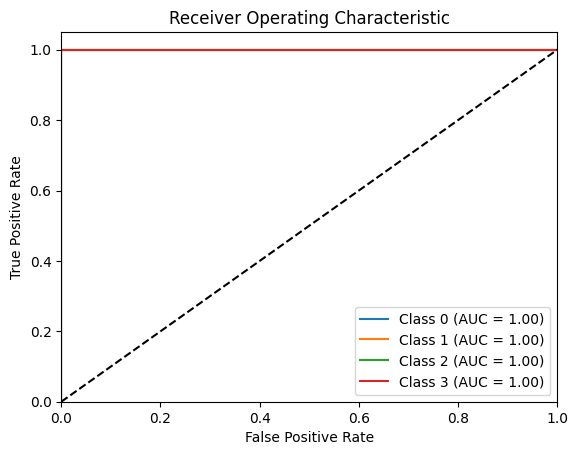

Resultados esperados:  tensor([3., 3., 0., 0., 0., 2., 2., 1.])
Resultados obtenidos:  tensor([3, 3, 0, 0, 0, 2, 2, 1])


In [18]:
#=====  Instaciar modelo  =====#
input_size = X_train_tensor.shape[1]
hidden_sizes = [64, 64, 64, 64]       
num_classes = 4
activation = F.relu
model = MLP(input_size, hidden_sizes, num_classes, activation)   

# Definir la función de loss y optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
num_epochs = 100
print('|==========  Entrenando el modelo  ==========|\n')
start_time = time.time()
# Entrenar el modelo
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_onehot)
    loss.backward()
    optimizer.step()
    # Imprimir el training loss
    if (epoch+1) % 10 == 0:
        print(f"Epoch: {epoch+1}/{num_epochs}, Loss: {loss.item()}")
end_time = time.time()
time_taken = end_time - start_time

print('\n|==========  Resultados conjunto de prueba  ==========|\n')
# Evaluar el modelo con el conjunto de testing
outputs = model(X_test_tensor)
_, predicted = torch.max(outputs.data, 1)

# Obtener métricas
computeMetrics(y_test_tensor, predicted, time_taken)
print('Resultados esperados: ', y_test_tensor[:8])
print('Resultados obtenidos: ', predicted[:8])

print('\n1==========  Resultados conjunto de entrenamiento  ==========|\n')
# Evaluar el modelo con el conjunto de training
outputs = model(X_train_tensor)
_, predicted = torch.max(outputs.data, 1)

# Obtener métricas
computeMetrics(y_train_tensor, predicted, time_taken)
print('Resultados esperados: ', y_train_tensor[:8])
print('Resultados obtenidos: ', predicted[:8])

## MLP con feature extractor LBP

In [4]:
#=====  Feature Extractor  =====#
def lbp(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    lbp_image = np.zeros_like(gray)
    for i in range(1, gray.shape[0] - 1):
        for j in range(1, gray.shape[1] - 1):
            binary = ""
            center = gray[i, j]
            for x, y in [(-1, -1), (-1, 0), (-1, 1), (0, 1), (1, 1), (1, 0), (1, -1), (0, -1)]:
                if gray[i + x, j + y] >= center:
                    binary += "1"
                else:
                    binary += "0"
            lbp_image[i, j] = int(binary, 2)
    return lbp_image.flatten()

In [6]:
#=====  Cargar y aplicar feature extractor a las imágenes  =====#
lbp_arrays = []
lbp_labels = []

input_folders = ["./testi3/", "./testi4/", "./testi2/", "./testi/"]
#input_folders = ["drive/MyDrive/COVID-19_Radiography_Dataset/COVID/", "drive/MyDrive/COVID-19_Radiography_Dataset/Lung_Opacity/",
#                 "drive/MyDrive/COVID-19_Radiography_Dataset/Normal/", "drive/MyDrive/COVID-19_Radiography_Dataset/Viral_Pneumonia/"]
i = 0
for folder in input_folders:
    input_folder = folder
    for filename in os.listdir(input_folder):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            image_path = os.path.join(input_folder, filename)
            image = cv2.imread(image_path)
            cropped_image = image[20:280, 20:280]                           # Recortar los bordes
            #gray_image = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2GRAY)    # Pasarla a escala de grises
            lbp_array = lbp(cropped_image)                                     # Aplicar feature extractor
            image_np = np.array(lbp_array).flatten()                        # COnvertirla en array de 1D
            lbp_arrays.append(image_np)
            lbp_labels.append(i)
    i+=1

np.save("lbp_arrays.npy", lbp_arrays)
np.save("lbp_labels.npy", lbp_labels)
#np.save("drive/MyDrive/lbp_arrays.npy", lbp_arrays)
#np.save("drive/MyDrive/lbp_labels.npy", lbp_labels)

In [10]:
#=====  Feature Engineering  =====#

try:
    lbp_arrays_charged = np.load("lbp_arrays.npy")
    labels_charged = np.load("lbp_labels.npy")
    #lbp_arrays_charged = np.load("drive/MyDrive/lbp_arrays.npy")
    #labels_charged = np.load("drive/MyDrive/lbp_labels.npy")
except FileNotFoundError:
    print("Error: File not found.")
   
# Convertir las listas a numpy array de tipo uint8
lbp_np_arrays = np.array(lbp_arrays_charged, dtype=np.uint8)
labels_np = np.array(labels_charged)

# Normalización de los datos
scaler = MinMaxScaler()
scaler.fit(lbp_np_arrays)
scaled_data = scaler.transform(lbp_np_arrays)
lbp_np_arrays = scaled_data

# Dividir los datos en train y test y estratificar
train_lbp, test_lbp, train_labels, test_labels = train_test_split(
    lbp_np_arrays, labels_np, test_size=0.2, stratify=labels_np, random_state=42)

# Convertir de numpy array a PyTorch tensor
lbp_train_tensor = torch.from_numpy(train_lbp).float()
lbp_test_tensor = torch.from_numpy(test_lbp).float()
labels_train_tensor = torch.from_numpy(train_labels).float()
labels_test_tensor = torch.from_numpy(test_labels).float()

# Convertir a tensores de tipo long
labels_train_long_tensor = labels_train_tensor.long()         

# Convertir a one hot
labels_onehot = F.one_hot(labels_train_long_tensor, num_classes=4).float()



In [7]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, num_classes, activation):
        super(MLP, self).__init__()
        self.input_size = input_size
        self.hidden_layers = nn.ModuleList()
        self.num_classes = num_classes
        self.activation = activation
        # Agregar capas ocultas
        for i, hidden_size in enumerate(hidden_sizes):
            if i == 0:
                self.hidden_layers.append(nn.Linear(input_size, hidden_size))
            else:
                self.hidden_layers.append(nn.Linear(hidden_sizes[i-1], hidden_size))
        # Capa de salida
        self.output_layer = nn.Linear(hidden_sizes[-1], num_classes)
        
    def forward(self, x):
        out = x
        # Pasar por capas ocultas
        for layer in self.hidden_layers:
            out = layer(out)
            out = self.activation(out)
        # Pasar por capa de salida
        out = self.output_layer(out)
        return out

### Diseño # 1
Capas: [67600, 128, 64, 4] | Función de activación: ReLU | epochs = 100

|==========  Entrenando el modelo  ==========|

Epoch: 10/100, Loss: 2.789644718170166
Epoch: 20/100, Loss: 0.9128507375717163
Epoch: 30/100, Loss: 0.5305532217025757
Epoch: 40/100, Loss: 0.34595468640327454
Epoch: 50/100, Loss: 0.17992296814918518
Epoch: 60/100, Loss: 0.10947564244270325
Epoch: 70/100, Loss: 0.0712537169456482
Epoch: 80/100, Loss: 0.04843071475625038
Epoch: 90/100, Loss: 0.03652949631214142
Epoch: 100/100, Loss: 0.028556011617183685

|==========  Resultados conjunto de prueba  ==========|



/home/jose/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Accuracy,Precision,Recall,F1 Score,AUC,Tiempo de entrenamiento
0,0.592593,0.561111,0.541667,0.507692,0.698465,12.989404


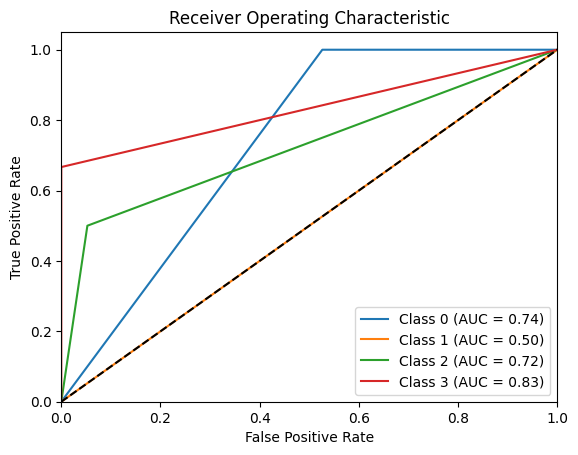

Resultados esperados:  tensor([1., 0., 0., 3., 2., 2., 0., 2.])
Resultados obtenidos:  tensor([0, 0, 0, 3, 2, 2, 0, 2])

1==========  Resultados conjunto de entrenamiento  ==========|



,Accuracy,Precision,Recall,F1 Score,AUC,Tiempo de entrenamiento
0,1.0,1.0,1.0,1.0,1.0,12.989404


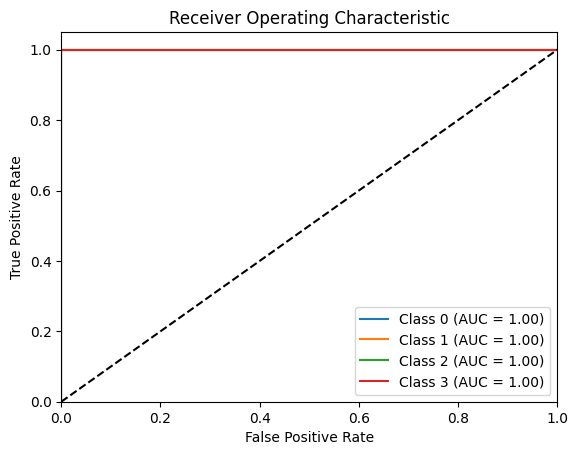

Resultados esperados:  tensor([3., 3., 0., 0., 0., 2., 2., 1.])
Resultados obtenidos:  tensor([3, 3, 0, 0, 0, 2, 2, 1])


In [11]:
#=====  Instaciar modelo  =====#
input_size = lbp_train_tensor.shape[1]
hidden_sizes = [128, 64]       
num_classes = 4
activation = F.relu
model = MLP(input_size, hidden_sizes, num_classes, activation)   

# Definir la función de loss y optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
num_epochs = 100
print('|==========  Entrenando el modelo  ==========|\n')
start_time = time.time()
# Entrenar el modelo
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(lbp_train_tensor)
    loss = criterion(outputs, labels_onehot)
    loss.backward()
    optimizer.step()
    # Imprimir el training loss
    if (epoch+1) % 10 == 0:
        print(f"Epoch: {epoch+1}/{num_epochs}, Loss: {loss.item()}")
end_time = time.time()
time_taken = end_time - start_time

print('\n|==========  Resultados conjunto de prueba  ==========|\n')
# Evaluar el modelo con el conjunto de testing
outputs = model(lbp_test_tensor)
_, predicted = torch.max(outputs.data, 1)

# Obtener métricas
computeMetrics(labels_test_tensor, predicted, time_taken)
print('Resultados esperados: ', labels_test_tensor[:8])
print('Resultados obtenidos: ', predicted[:8])

print('\n1==========  Resultados conjunto de entrenamiento  ==========|\n')
# Evaluar el modelo con el conjunto de training
outputs = model(lbp_train_tensor)
_, predicted = torch.max(outputs.data, 1)

# Obtener métricas
computeMetrics(labels_train_tensor, predicted, time_taken)
print('Resultados esperados: ', labels_train_tensor[:8])
print('Resultados obtenidos: ', predicted[:8])

### Diseño # 2
Capas: [67600, 256, 4] | Función de activación: ReLU | epochs = 100

|==========  Entrenando el modelo  ==========|

Epoch: 10/100, Loss: 4.974449157714844
Epoch: 20/100, Loss: 1.569401502609253
Epoch: 30/100, Loss: 0.9252034425735474
Epoch: 40/100, Loss: 0.6738854646682739
Epoch: 50/100, Loss: 0.4479357600212097
Epoch: 60/100, Loss: 0.2926907241344452
Epoch: 70/100, Loss: 0.1881953775882721
Epoch: 80/100, Loss: 0.1221727654337883
Epoch: 90/100, Loss: 0.08197478204965591
Epoch: 100/100, Loss: 0.0586363710463047

|==========  Resultados conjunto de prueba  ==========|



/home/jose/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Accuracy,Precision,Recall,F1 Score,AUC,Tiempo de entrenamiento
0,0.555556,0.542763,0.510417,0.473148,0.676261,10.946448


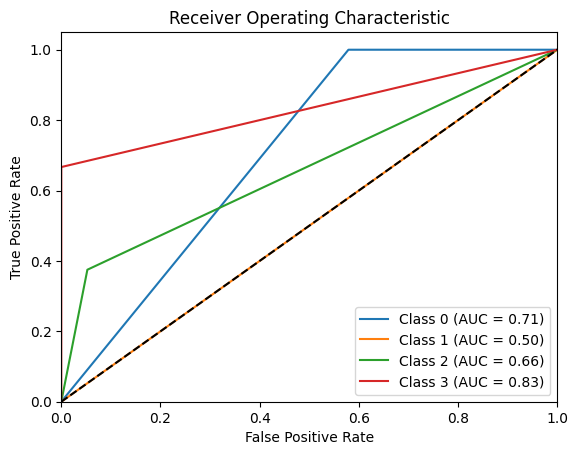

Resultados esperados:  tensor([1., 0., 0., 3., 2., 2., 0., 2.])
Resultados obtenidos:  tensor([0, 0, 0, 3, 2, 2, 0, 2])

1==========  Resultados conjunto de entrenamiento  ==========|



,Accuracy,Precision,Recall,F1 Score,AUC,Tiempo de entrenamiento
0,1.0,1.0,1.0,1.0,1.0,10.946448


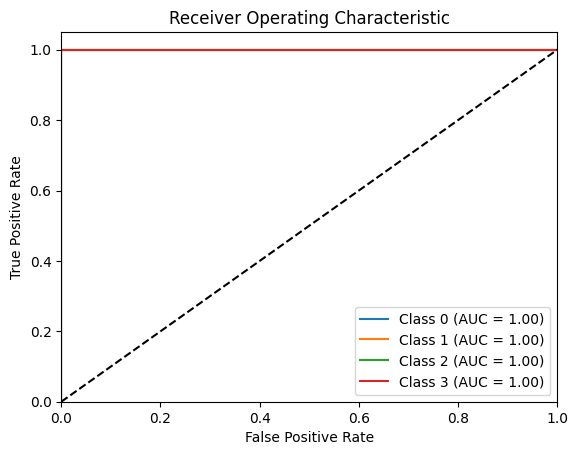

Resultados esperados:  tensor([3., 3., 0., 0., 0., 2., 2., 1.])
Resultados obtenidos:  tensor([3, 3, 0, 0, 0, 2, 2, 1])


In [12]:
#=====  Instaciar modelo  =====#
input_size = lbp_train_tensor.shape[1]
hidden_sizes = [128, 64]       
num_classes = 4
activation = F.relu
model = MLP(input_size, hidden_sizes, num_classes, activation)   

# Definir la función de loss y optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
num_epochs = 100
print('|==========  Entrenando el modelo  ==========|\n')
start_time = time.time()
# Entrenar el modelo
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(lbp_train_tensor)
    loss = criterion(outputs, labels_onehot)
    loss.backward()
    optimizer.step()
    # Imprimir el training loss
    if (epoch+1) % 10 == 0:
        print(f"Epoch: {epoch+1}/{num_epochs}, Loss: {loss.item()}")
end_time = time.time()
time_taken = end_time - start_time

print('\n|==========  Resultados conjunto de prueba  ==========|\n')
# Evaluar el modelo con el conjunto de testing
outputs = model(lbp_test_tensor)
_, predicted = torch.max(outputs.data, 1)

# Obtener métricas
computeMetrics(labels_test_tensor, predicted, time_taken)
print('Resultados esperados: ', labels_test_tensor[:8])
print('Resultados obtenidos: ', predicted[:8])

print('\n1==========  Resultados conjunto de entrenamiento  ==========|\n')
# Evaluar el modelo con el conjunto de training
outputs = model(lbp_train_tensor)
_, predicted = torch.max(outputs.data, 1)

# Obtener métricas
computeMetrics(labels_train_tensor, predicted, time_taken)
print('Resultados esperados: ', labels_train_tensor[:8])
print('Resultados obtenidos: ', predicted[:8])

### Diseño # 3
Capas: [67600, 64, 64, 64, 64, 4] | Función de activación: ReLU | epochs = 100

|==========  Entrenando el modelo  ==========|

Epoch: 10/100, Loss: 1.095219373703003
Epoch: 20/100, Loss: 0.3942318558692932
Epoch: 30/100, Loss: 0.046788617968559265
Epoch: 40/100, Loss: 0.004325117915868759
Epoch: 50/100, Loss: 0.0009795556543394923
Epoch: 60/100, Loss: 0.0004768750804942101
Epoch: 70/100, Loss: 0.00031753157963976264
Epoch: 80/100, Loss: 0.00023275626881513745
Epoch: 90/100, Loss: 0.00017095079238060862
Epoch: 100/100, Loss: 0.00012005727330688387

|==========  Resultados conjunto de prueba  ==========|



,Accuracy,Precision,Recall,F1 Score,AUC,Tiempo de entrenamiento
0,0.62963,0.674107,0.58125,0.576163,0.725733,5.669346


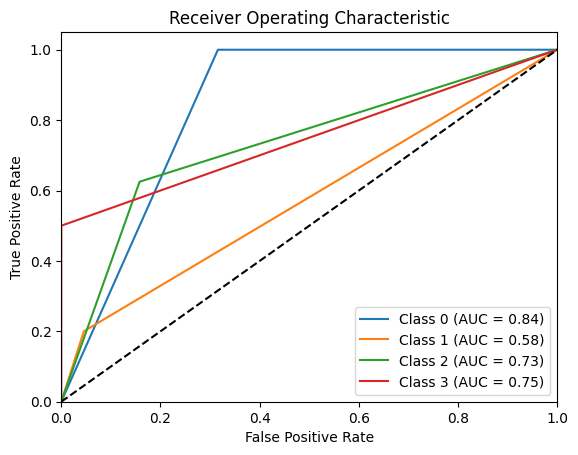

Resultados esperados:  tensor([1., 0., 0., 3., 2., 2., 0., 2.])
Resultados obtenidos:  tensor([0, 0, 0, 3, 2, 2, 0, 2])

1==========  Resultados conjunto de entrenamiento  ==========|



,Accuracy,Precision,Recall,F1 Score,AUC,Tiempo de entrenamiento
0,1.0,1.0,1.0,1.0,1.0,5.669346


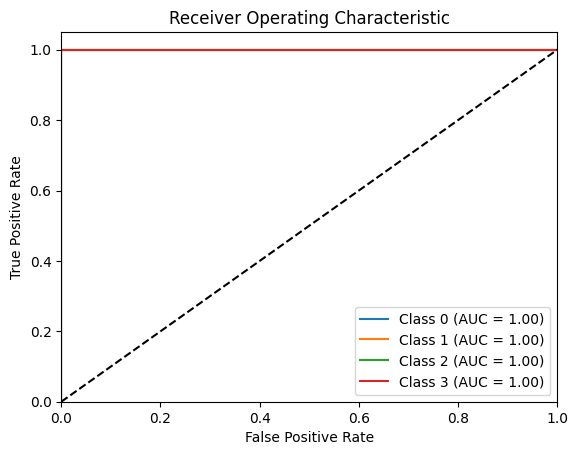

Resultados esperados:  tensor([3., 3., 0., 0., 0., 2., 2., 1.])
Resultados obtenidos:  tensor([3, 3, 0, 0, 0, 2, 2, 1])


In [19]:
#=====  Instaciar modelo  =====#
input_size = lbp_train_tensor.shape[1]
hidden_sizes = [64, 64, 64, 64]       
num_classes = 4
activation = F.relu
model = MLP(input_size, hidden_sizes, num_classes, activation)   

# Definir la función de loss y optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
num_epochs = 100
print('|==========  Entrenando el modelo  ==========|\n')
start_time = time.time()
# Entrenar el modelo
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(lbp_train_tensor)
    loss = criterion(outputs, labels_onehot)
    loss.backward()
    optimizer.step()
    # Imprimir el training loss
    if (epoch+1) % 10 == 0:
        print(f"Epoch: {epoch+1}/{num_epochs}, Loss: {loss.item()}")
end_time = time.time()
time_taken = end_time - start_time

print('\n|==========  Resultados conjunto de prueba  ==========|\n')
# Evaluar el modelo con el conjunto de testing
outputs = model(lbp_test_tensor)
_, predicted = torch.max(outputs.data, 1)

# Obtener métricas
computeMetrics(labels_test_tensor, predicted, time_taken)
print('Resultados esperados: ', labels_test_tensor[:8])
print('Resultados obtenidos: ', predicted[:8])

print('\n1==========  Resultados conjunto de entrenamiento  ==========|\n')
# Evaluar el modelo con el conjunto de training
outputs = model(lbp_train_tensor)
_, predicted = torch.max(outputs.data, 1)

# Obtener métricas
computeMetrics(labels_train_tensor, predicted, time_taken)
print('Resultados esperados: ', labels_train_tensor[:8])
print('Resultados obtenidos: ', predicted[:8])

# CNN